# Projeto 3
O objetivo desse projeto é trabalhar com operações 

# Setup
Setup inicial, ao final deveria aparecer a imagem desejada

In [76]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install opencv-python

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


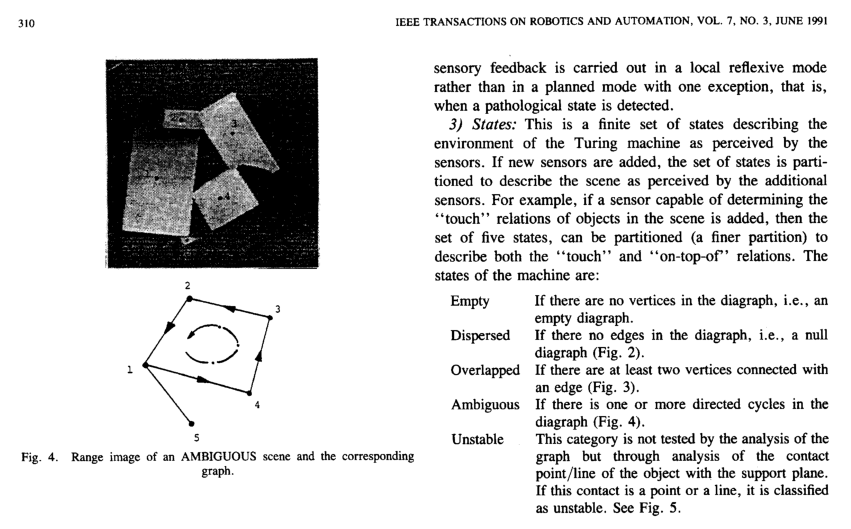

In [77]:
# Test setup, should show the bitmap.png image
from skimage.morphology import binary_opening, binary_closing, binary_dilation
import matplotlib.pyplot as plt
import cv2
import numpy as np

figsize = (5*3, 3.6*4)

img = cv2.imread('bitmap.pbm', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=figsize, constrained_layout=False)
plt.axis('off')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.savefig('results/original.png', bbox_inches='tight')


# Passos 1 a 6
  - Dilatação e erosão (fechamento) da imagem com elemento estruturante com 1 pixel de altura e 200 de largura
  - Dilatação e erosão (fechamento) da imagem  com elemento estruturante com 200 pixel de altura e 1 de largura
  - AND com os fechamentos
  - Fechamento com elemento estruturante 1 pixel de altura e 30 de largura

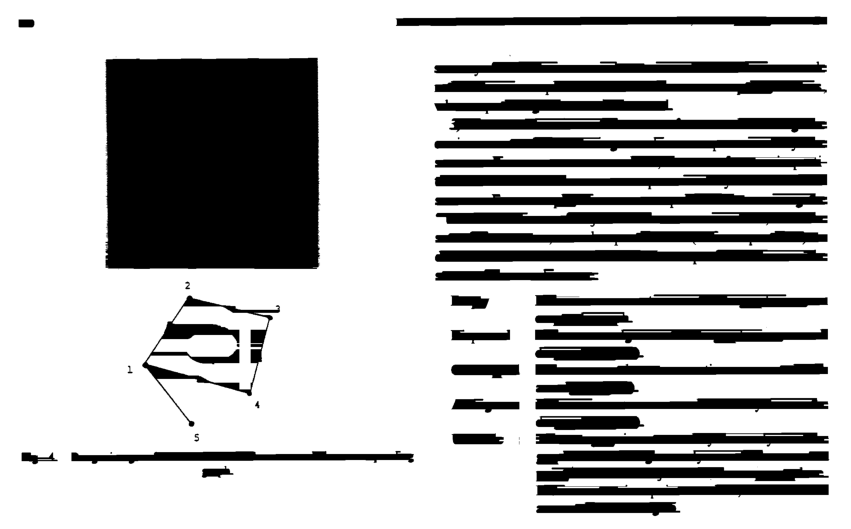

In [89]:
def to_bin(img):
    return ~((img / 255).astype(np.bool))

def to_255(img):
    return ((~img) * 255).astype(np.uint8)

row_closing = np.ones((1, 100))
column_closing = np.ones((200, 1))
closing_structure_6=np.ones((1,30))

bin_input_img = to_bin(img)

# 1) e 2)
row = binary_closing(bin_input_img, selem=row_closing)
# 3) e 4)
column = binary_closing(bin_input_img, selem=column_closing)

# 5)
bin_img = row & column

# 6)
bin_img = binary_closing(bin_img, selem=closing_structure_6)

plt.figure(figsize=figsize, constrained_layout=False)
plt.axis('off')
plt.imshow(to_255(bin_img), cmap='gray', vmin=0, vmax=255)
plt.savefig('results/linesPrep.png', bbox_inches='tight')


# Identificação de componentes conexos

In [96]:
def connected_components(img):
    _, _, stats, _ = cv2.connectedComponentsWithStats(255*img.astype(np.uint8), 4, cv2.CV_32S)
    return stats[1:]

In [101]:
def count_transitions(img, min_x, min_y, w, h):
    img_h, img_w = img.shape
    ntrans = 0

    for dy in range(h):
        for dx in range(w):
            x = min_x+dx
            y = min_y+dy

            if x < img_w and y < img_h and img[y,x]:
                if x-1 >= min_x and not img[y,x-1]:
                    ntrans += 1
                if y-1 >= min_y and not img[y-1,x]:
                    ntrans += 1

    return ntrans

stats = connected_components(bin_img)
ratios = []

for label in stats:
    min_x, min_y, w, h, area = label

    ntrans = count_transitions(bin_img, min_x, min_y, w, h)
    area_ratio = area / (w*h)
    trans_ratio = ntrans / area
    ratios.append((area_ratio, trans_ratio))

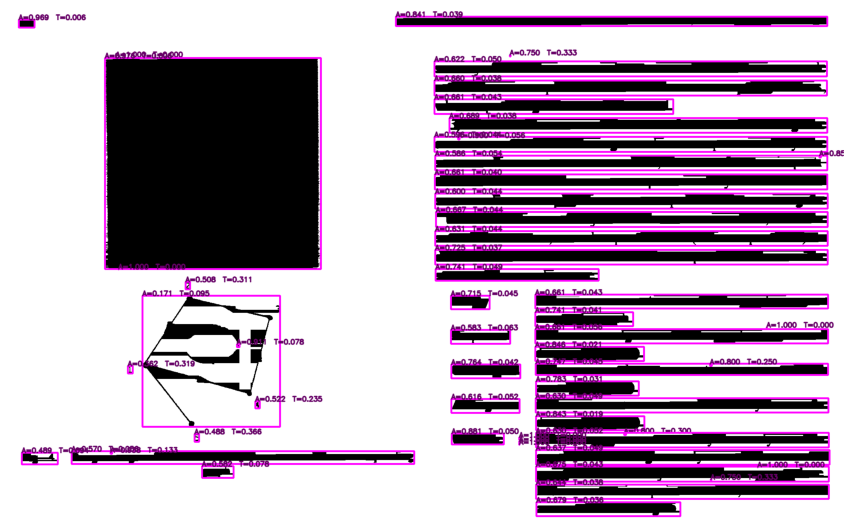

In [102]:
def draw(img, stats, ratios=None):
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for label, stat in enumerate(stats):
        min_x, min_y, w, h, area = stat
        cv2.rectangle(img, (min_x, min_y), (min_x+w, min_y+h), (255, 0, 255), 4)

        if ratios:
            area_ratio, trans_ratio = ratios[label]
            cv2.putText(img, 'A=%.3f  T=%.3f' % (area_ratio, trans_ratio), (min_x, min_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (102, 0, 102), 2, cv2.LINE_AA)

    return img



blobs_img = draw(to_255(bin_img), stats, ratios=ratios)
plt.figure(figsize=figsize, constrained_layout=False)
plt.axis('off')
plt.imshow(blobs_img, cmap='gray', vmin=0, vmax=255)
plt.savefig('results/linesWithRatios.png', bbox_inches='tight')

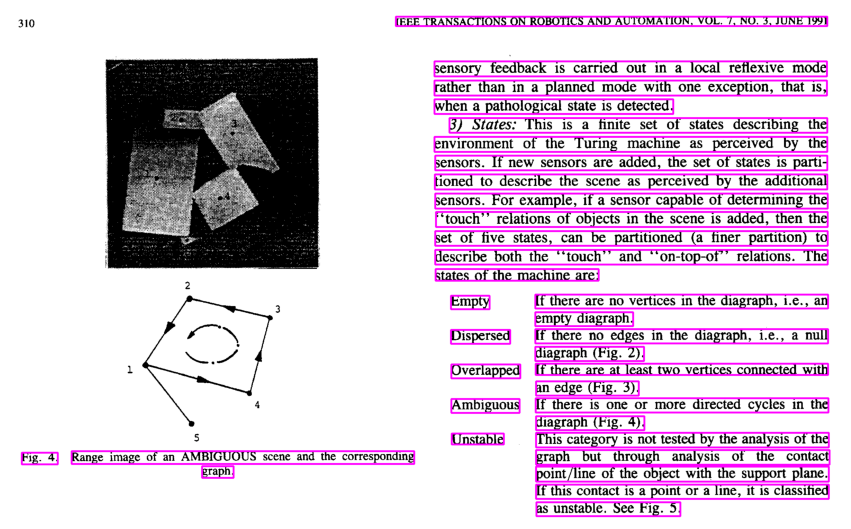

In [104]:
def find_text(stats, ratios):
    a_thr = (.4, .9)
    t_thr = (0, .1)

    filtered_stats = []
    for label, stat in enumerate(stats):
        a, t = ratios[label]
        if a_thr[0] < a < a_thr[1] and t_thr[0] < t < t_thr[1]:
            filtered_stats.append(stat)

    return filtered_stats

text_stats = find_text(stats, ratios)
text_blobs_img = draw(img, text_stats)
plt.figure(figsize=figsize, constrained_layout=False)
plt.imshow(text_blobs_img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.savefig('results/linesSeg.png', bbox_inches='tight')

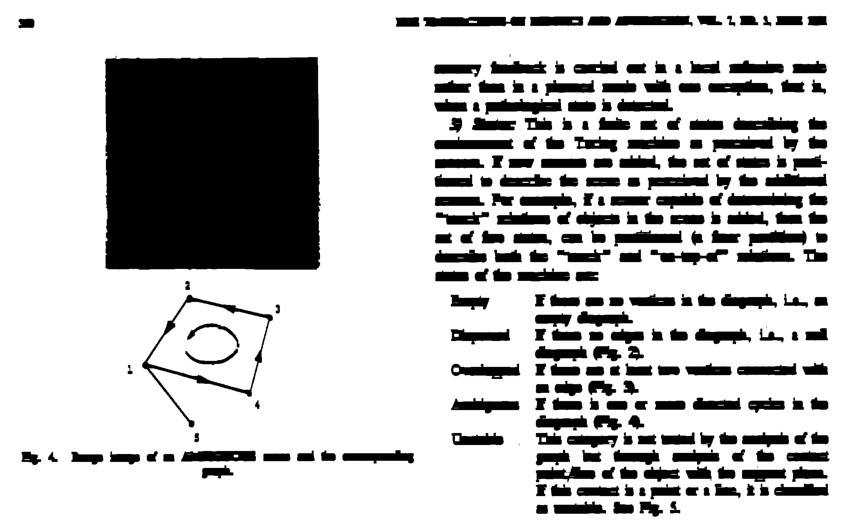

In [105]:
def process_words(bin_img):
    words_height=np.ones((5, 1))
    words_horizontal=np.ones((1, 12))
    bin_img = binary_dilation(bin_img, selem=words_height)
    bin_img = binary_closing(bin_img, selem=words_horizontal)
    
    return bin_img

words = process_words(bin_input_img)
words_stats = connected_components(words)
plt.figure(figsize=figsize, constrained_layout=False)
plt.imshow(to_255(words), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.savefig('results/wordsMorph.png', bbox_inches='tight')

## Operações morfológicas para segmentação de linhas em palavras

There are 34 lines and 237 words


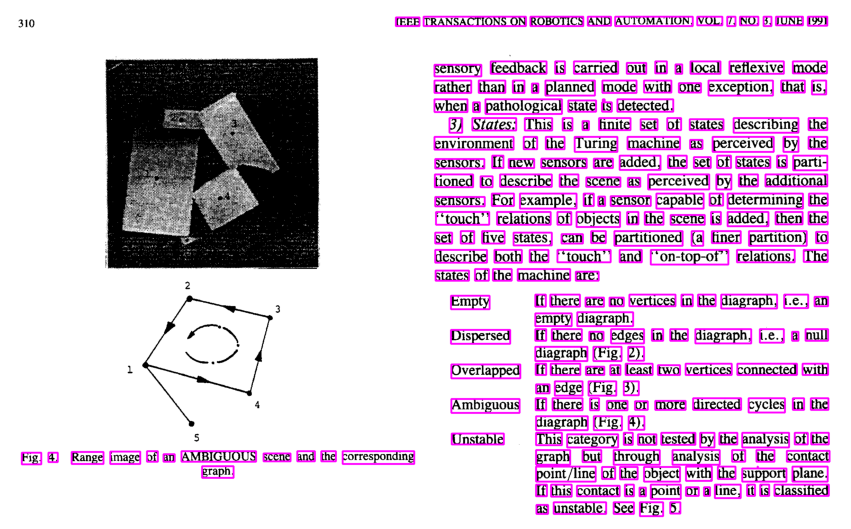

In [106]:
def create_mask(stats, shape):
    mask = np.zeros(shape)

    for stat in stats:
        min_x, min_y, w, h, __ = stat
        mask[min_y:min_y+h, min_x:min_x+w] = 1

    return mask.astype(np.bool)

words_mask = create_mask(words_stats, bin_img.shape) & create_mask(text_stats, bin_img.shape)

words_stats = connected_components(words_mask)
words_blobs_img = draw(img, words_stats)
plt.figure(figsize=figsize, constrained_layout=False)
plt.imshow(words_blobs_img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.savefig('results/wordsSeg.png', bbox_inches='tight')

print('There are {} lines and {} words'.format(len(text_stats), len(words_stats)))

